In [26]:
import keras
from keras import models, layers
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import os
from scipy.ndimage import imread
from scipy.misc import imresize
from nbutil import imshow_multi
from keras.backend import tf as ktf

In [32]:
dir = '../data/scenerec'

categories = [c for c in os.listdir(os.path.join(dir, 'train')) if c[0] != '.']

SIZE = 64

def load_dataset(name):
    images = []
    labels = []
    for cat in categories:
        for filename in os.listdir(os.path.join(dir, name, cat)):
            if filename.endswith('.jpg'): 
                path = os.path.join(dir, name, cat, filename)
                image = imread(path)
                h,w = image.shape[:2]
                # top-left crop
                if h > w:
                    image = image[:w, :]
                else:
                    image = image[:, :h]
                image = imresize(image, size=[SIZE, SIZE], mode='L')
                images.append(image)
                labels.append(categories.index(cat))
    images = np.expand_dims(np.stack(images) / 255.0, -1)
    labels = np.expand_dims(np.stack(labels).astype(int), -1)
    return images, labels

trainx, trainy = load_dataset('train')
testx, testy = load_dataset('test')


In [33]:
image_gen = ImageDataGenerator(rotation_range=5, 
                               zoom_range=0.2, 
                               width_shift_range=0.1, 
                               height_shift_range=0.1, 
                               horizontal_flip=True,
                               channel_shift_range=0.1)


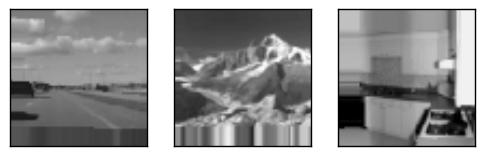

15


In [34]:
%matplotlib inline
for images, _ in image_gen.flow(trainx, trainy, batch_size=3):
    imshow_multi(images[:,:,:,0])
    break
print len(categories)


In [39]:
model = models.Sequential()
image_size = SIZE
prev_channels = 1
for i, channels in enumerate([64, 64, 128, 128, 256, 256]):
    model.add(layers.Conv2D(channels, 5, input_shape=[image_size, image_size, prev_channels], padding='same', activation='relu'))
    prev_channels = channels
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))
    model.add(layers.AveragePooling2D(pool_size=(2,2)))
    image_size /= 2
model.add(layers.Flatten())
model.add(layers.Dense(len(categories), activation='softmax'))
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_77 (Conv2D)           (None, 64, 64, 64)        1664      
_________________________________________________________________
batch_normalization_70 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
dropout_71 (Dropout)         (None, 64, 64, 64)        0         
_________________________________________________________________
average_pooling2d_41 (Averag (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 32, 32, 64)        102464    
_________________________________________________________________
batch_normalization_71 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
dropout_72 (Dropout)         (None, 32, 32, 64)        0         
__________

In [41]:
batch_size = 32

for i in xrange(40):
    model.fit_generator(image_gen.flow(trainx, trainy, batch_size=batch_size),
                       steps_per_epoch=len(trainx)/batch_size,
                       verbose=0,
                       epochs=1)
                       # validation_data=(testx, testy))
    score = model.evaluate(testx, testy, verbose=0)
    if i % 2 == 0:
        print 'epoch: {}, accuracy: {}'.format(i+1, score[1])

epoch: 1, accuracy: 0.637185929708
epoch: 3, accuracy: 0.651591289822
epoch: 5, accuracy: 0.652261306573
epoch: 7, accuracy: 0.637520938083
epoch: 9, accuracy: 0.618760469052
epoch: 11, accuracy: 0.655276381949
epoch: 13, accuracy: 0.634505862687
epoch: 15, accuracy: 0.612395309943
epoch: 17, accuracy: 0.63216080408
epoch: 19, accuracy: 0.667001675042
epoch: 21, accuracy: 0.680067001715
epoch: 23, accuracy: 0.660301507578
epoch: 25, accuracy: 0.653266331658
epoch: 27, accuracy: 0.658961474097
epoch: 29, accuracy: 0.676046901212
epoch: 31, accuracy: 0.673701842586
epoch: 33, accuracy: 0.677721943049
epoch: 35, accuracy: 0.681072026801
epoch: 37, accuracy: 0.650586264657
epoch: 39, accuracy: 0.626465661701


In [ ]:
score = model.evaluate(testx, testy, verbose=0)
print 'accuracy: {}'.format(score[1])